In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
## Data Prep

dataset = CIFAR10(
    root="data",
    train=True,
    transform=Compose([ToTensor(), Normalize(0.5, 0.5)]),
    download=True
)


0.1%

100.0%


Extracting data/cifar-10-python.tar.gz to data


tensor([[[[-0.1529,  0.1059,  0.2471,  ...,  0.0588,  0.2235,  0.1137],
          [-0.2549, -0.1216,  0.0824,  ..., -0.1294,  0.0118,  0.0824],
          [-0.2863, -0.2627,  0.0902,  ..., -0.2392, -0.0196,  0.0745],
          ...,
          [-0.3333, -0.3804, -0.4118,  ..., -0.3020, -0.3020, -0.2627],
          [-0.3020, -0.3333, -0.3804,  ..., -0.3725, -0.3490, -0.4118],
          [-0.2314, -0.2941, -0.3333,  ..., -0.4980, -0.5216, -0.5529]],

         [[-0.3020, -0.0902,  0.0039,  ..., -0.1137,  0.0431,  0.0667],
          [-0.3804, -0.2784, -0.0980,  ..., -0.2235, -0.0510,  0.0667],
          [-0.3961, -0.3725, -0.0275,  ..., -0.2627, -0.0353,  0.0353],
          ...,
          [-0.3804, -0.4275, -0.4667,  ..., -0.2549, -0.2471, -0.2000],
          [-0.3412, -0.3725, -0.4196,  ..., -0.3020, -0.2627, -0.3176],
          [-0.2706, -0.3333, -0.3725,  ..., -0.4039, -0.4196, -0.4431]],

         [[-0.5529, -0.3490, -0.2706,  ..., -0.3098, -0.1608, -0.2392],
          [-0.6471, -0.5294, -

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

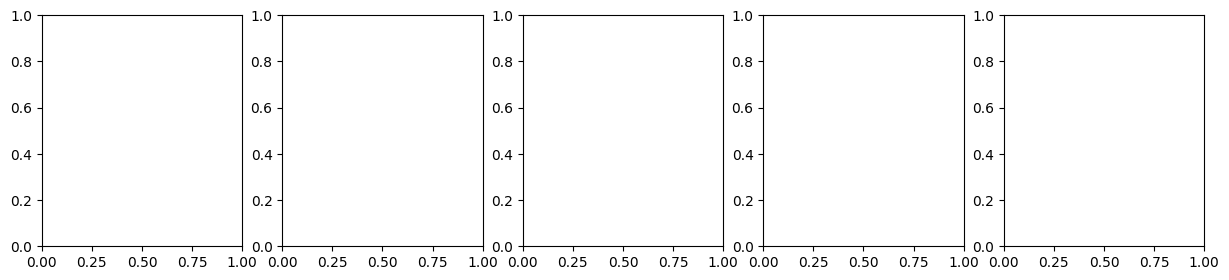

In [7]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for (X, y) in dataloader:
    print(X)
    print(y)
    break

import matplotlib.pyplot as plt

# Get the first five images and their corresponding labels
images = []
labels = []
for i, (image, label) in enumerate(dataloader):
    images.append(image)
    labels.append(label)
    if i == 4:
        break

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(images[i].squeeze().permute(1, 2, 0))
    axes[i].set_title(f"Label: {labels[i]}")

plt.show()

In [3]:
timesteps = np.linspace(80, 0, num_steps) # {80 ...., 0} for 100 elements

# SDE dictates smaller step sizes at low noise levels
sigma_max = 80
sigma_min = 0.002
rho = 7 # raise all elements to 7 while maintaining scale
steps = torch.arange(0, num_steps)
timesteps = ((sigma_max ** (1/rho)) + (steps / (num_steps - 1)) * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho #scale from 0, num_steps to 80, 0 following some root of step shape—looks like pixel value/time graph
print(timesteps)

NameError: name 'num_steps' is not defined

In [8]:
#ROUGH FORWARD PASS

num_steps = 100
img_shape = 28 * 28

x = torch.randn(img_shape) * timesteps[0]

for t_curr, t_next in zip(timesteps[:-1], timesteps[1:]):
    
    noise_level = t_next / t_curr
    
    x = x * noise_level + denoise(x, t_curr)
    

ValueError: operands could not be broadcast together with shapes (99,) (100,) 

In [ ]:
#BACKWARD PASS
for real_img in data:
    sigma = np.uniform(0, 80) # noise level
    
    noised_image = real_img + sigma * torch.randn_like(real_img)
    
    denoise_image = denoise(noisy_image, sigma) # must give it a noise level as input so it knows how many times to denoise, etc.
    
    loss = mse(denoise_image, noise_image)
    
    #train denoiser

# Issues w above
noise_image is now scaled to a potentially large value—can be tricky to train and generally unoptimal to have varying input image sizes
scale down

In [ ]:
data_var = 0.5

def denoise(noisy_img, sigma):
    noisy_img_var = sigma**2 + data_var**2
    scaled_noisy_img = noisy_img / noisy_img_var ** 0.5
    return net(scaled_noisy_img, sigma) #optionally, scale sigma to -1 to 1 via log fn

# predicting image vs noise

most models forward pass involve predicting noise given a noisy_img and a sigma level—clean img reconstructed by noisy_img - noise

dynamically adjust how much of the noisy_img is recycled during training (i.e. c_skip should increase in training) and modify return value:

In [ ]:
def denoise(noisy_img, sigma):
    sample_img_var = sigma**2 + data_var**2
    scaled_noisy_img = noisy_img / sample_img_var**2
    return c_skip * noisy_img + c_out * net(scaled_noisy_img, sigma)

# varying loss update sizes
due to c_skip, c_out, and other denoising reasons—the gradient updates has varying magnitude based on the current noise level—adjust loss weight some how!
# allocating training effort
weight could potentially be taken advantage of to train the network specifically on certain noise levels—dedicating network capacity where it ocunts. however this can be performed without scaling the magnitude of the losses simply by sampling noises by sampling noise levels during training with a particular probability disttribution that allocates where needed

In [ ]:
# final soln
sigma_data = 0.5 # from transform
P_mean = -1.2       # average noise level (logarithmic)
P_std = 1.2     # spread of random noise levels

def net(scaled_img, scaled_noise):
    some_noise = torch.randn_like(scaled_img)
    return some_noise # the net outputs noise! subtract noise from the dirty_image to get cleaner!

def denoise(noisy_image, sigma):
        # Input, output and skip scale
        c_in = 1 / torch.sqrt(sigma_data**2 + sigma**2)
        c_out = sigma * sigma_data / torch.sqrt(sigma**2 + sigma_data**2)
        c_skip = sigma_data**2 / (sigma**2 + sigma_data**2)
        c_noise = torch.log(sigma) / 4      # noise label warp
 
        # mix the input and network output to extract the clean image
        return c_skip * noisy_image + \
                   c_out  * net(c_in * noisy_image, c_noise)
                   
# training
for clean_image in range(1):
    sigma = np.exp(P_mean + P_std * torch.randn([]))
    
    noisy_image = clean_image + sigma * torch.randn_like(clean_image)
    
    denoised_image = denoise(noisy_image)
    
    weight = (sigma**2 + sigma_data**2) / (sigma * sigma_data)**2
    loss = weight * (denoised_image - clean_image).square().sum()